# Combined Data

(4407, 30)
(490, 30)
4897
(3917, 30)
(980, 30)
4897
(3427, 30)
(1470, 30)
4897
(2938, 30)
(1959, 30)
4897
(2448, 30)
(2449, 30)
4897


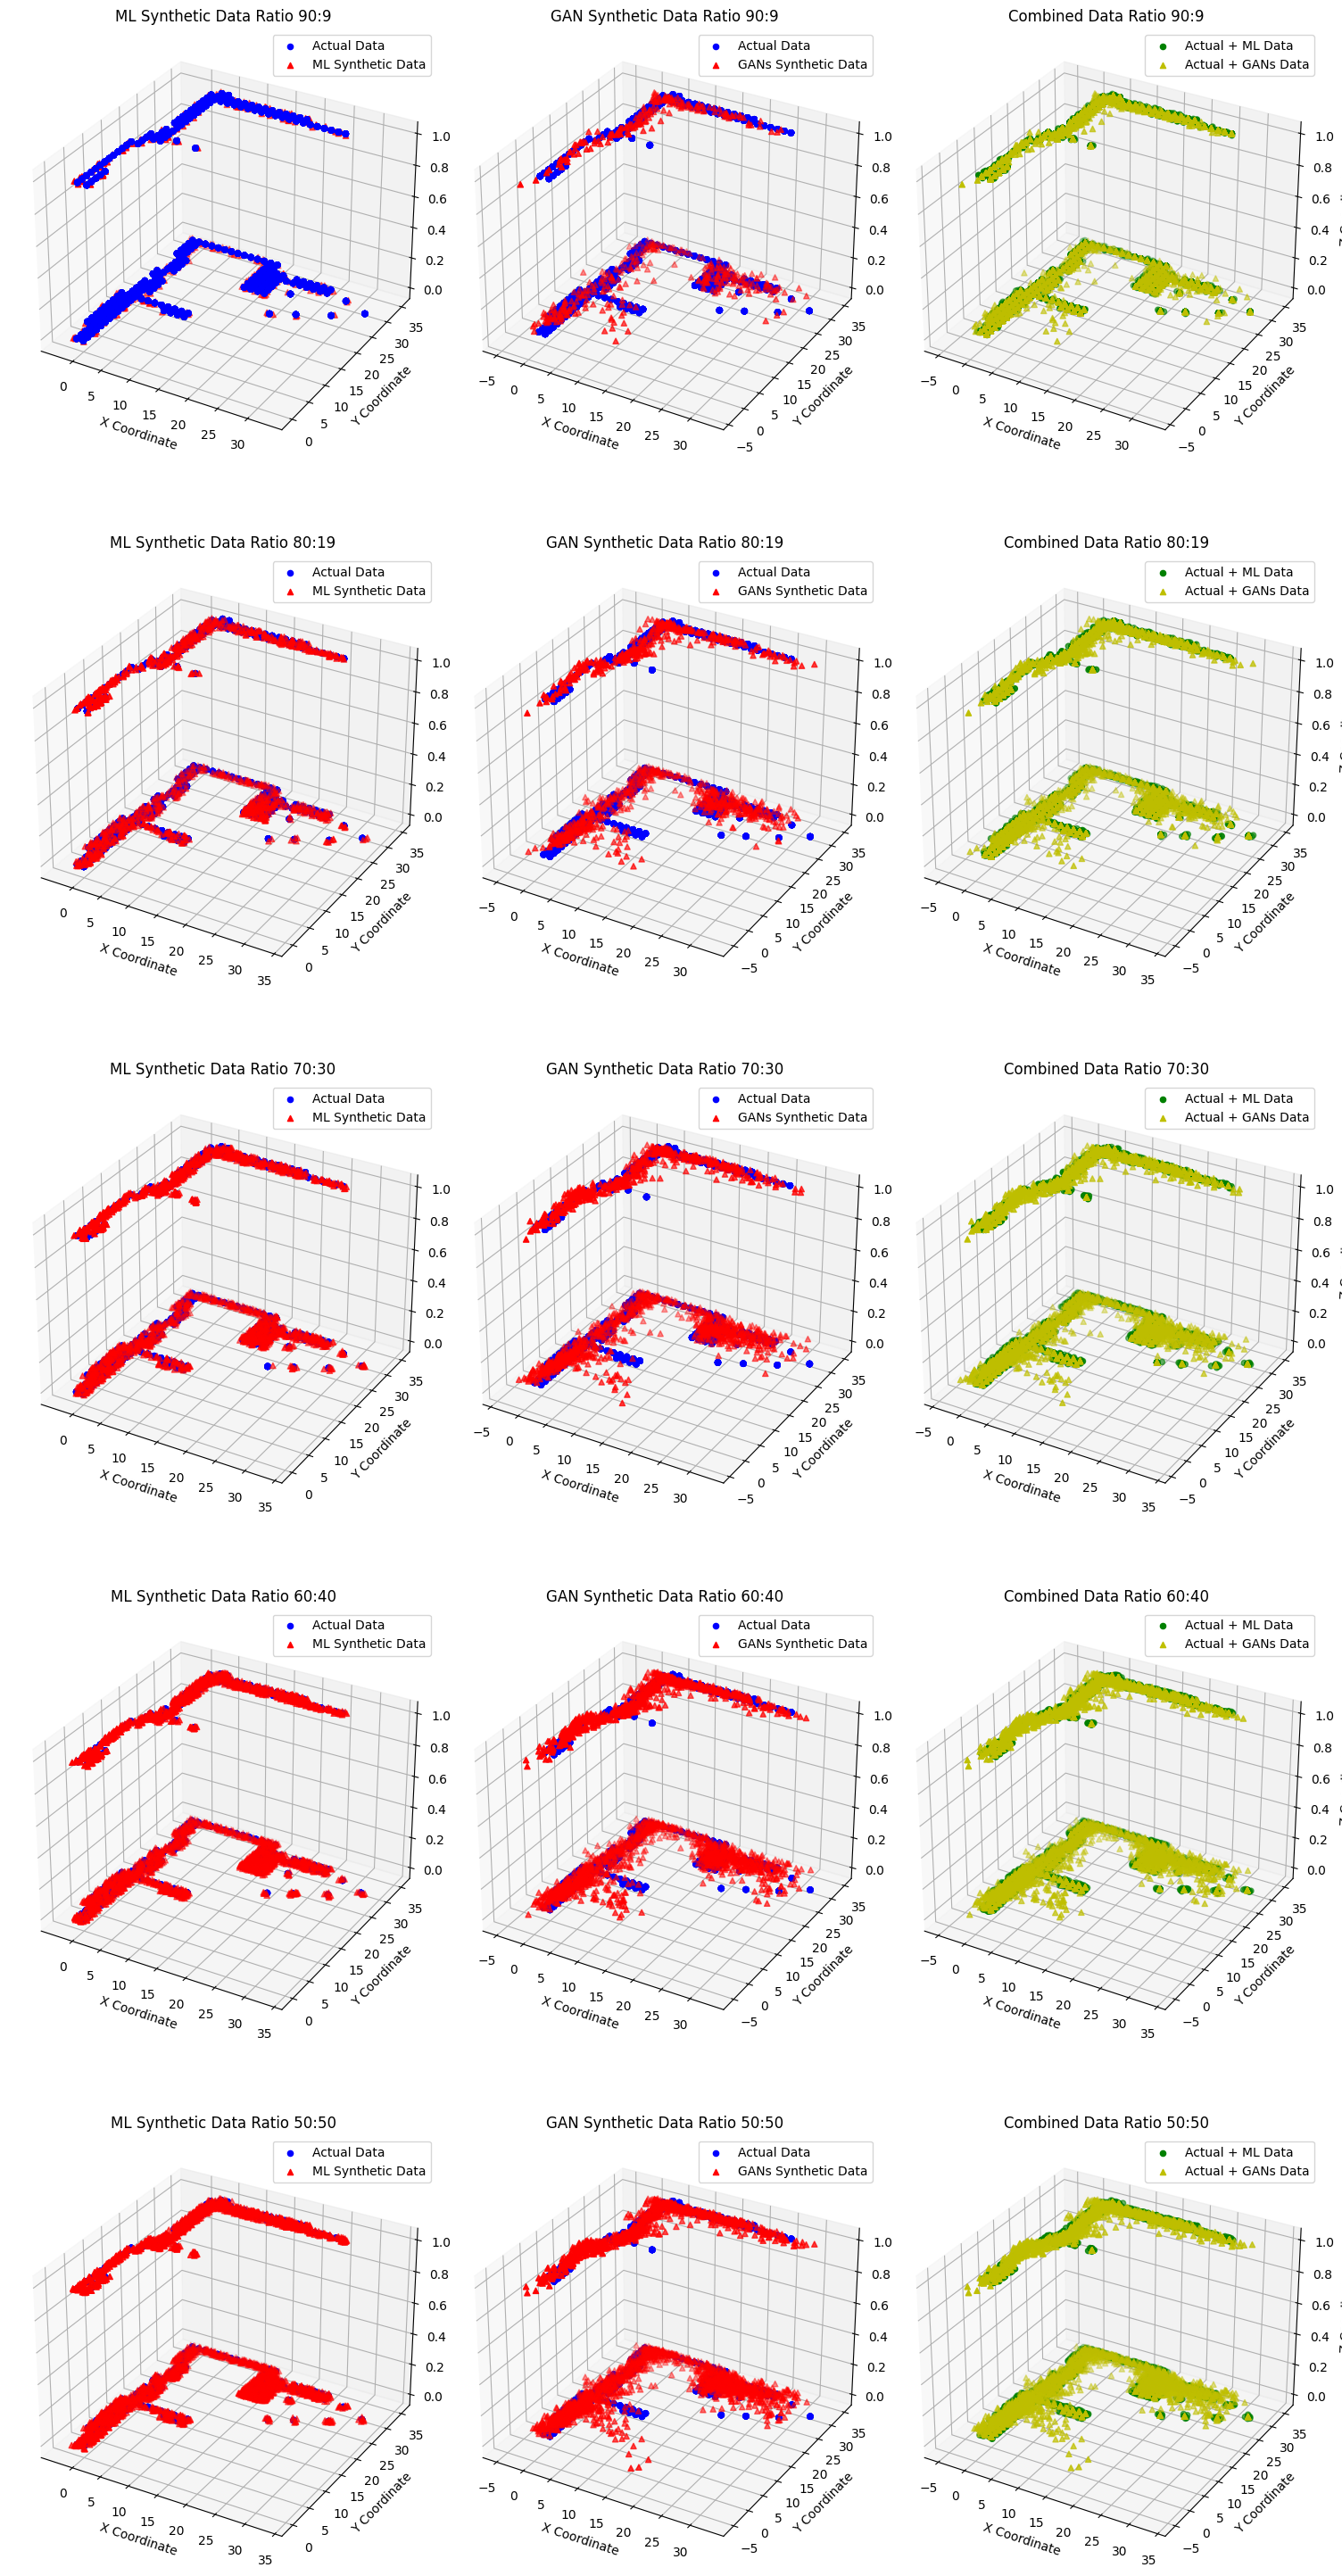

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load datasets
actual_data = pd.read_csv('original_CMKL1.csv')
synthetic_data_ml = pd.read_csv('synthetic_data_RandomSeaerch_Ensemble.csv')
synthetic_data_gan = pd.read_csv('GANs_synthetic_data.csv')

# Function to create dataset with given ratio for each floor
def create_combined_dataset(actual_data, synthetic_data, ratio):
    combined_data = pd.DataFrame()
    floors = actual_data['z'].unique()
    for floor in floors:
        actual_floor_data = actual_data[actual_data['z'] == floor]
        synthetic_floor_data = synthetic_data[synthetic_data['z'] == floor]
        
        n_actual = int(len(actual_floor_data) * ratio)
        n_synthetic = len(actual_floor_data) - n_actual
        
        actual_sample = actual_floor_data.sample(n_actual)
        synthetic_sample = synthetic_floor_data.sample(n_synthetic)
        
        actual_sample['type'] = 'actual'
        synthetic_sample['type'] = 'synthetic'
        
        combined_floor_data = pd.concat([actual_sample, synthetic_sample])
        combined_data = pd.concat([combined_data, combined_floor_data])
        
    return combined_data.reset_index(drop=True)

# Ratios to test
ratios = [0.9, 0.8, 0.7, 0.6, 0.5]

fig = plt.figure(figsize=(15, 30))

for i, ratio in enumerate(ratios):
    # Create combined dataset for ML synthetic data
    combined_data_ml = create_combined_dataset(actual_data, synthetic_data_ml, ratio)
    
    # Plotting for ML synthetic data
    ax = fig.add_subplot(len(ratios), 3, i*3+1, projection='3d')
    actual_points_ml = combined_data_ml[combined_data_ml['type'] == 'actual']
    synthetic_points_ml = combined_data_ml[combined_data_ml['type'] == 'synthetic']
    
    print(actual_points_ml.shape)
    print(synthetic_points_ml.shape)
    print(actual_points_ml.shape[0] + synthetic_points_ml.shape[0])
    
    ax.scatter(actual_points_ml['x'], actual_points_ml['y'], actual_points_ml['z'], c='b', marker='o', label='Actual Data')
    ax.scatter(synthetic_points_ml['x'], synthetic_points_ml['y'], synthetic_points_ml['z'], c='r', marker='^', label='ML Synthetic Data')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title(f'ML Synthetic Data Ratio {int(ratio*100)}:{int((1-ratio)*100)}')
    ax.legend()

    # Create combined dataset for GAN synthetic data
    combined_data_gan = create_combined_dataset(actual_data, synthetic_data_gan, ratio)
    
    # Plotting for GAN synthetic data
    ax = fig.add_subplot(len(ratios), 3, i*3+2, projection='3d')
    actual_points_gan = combined_data_gan[combined_data_gan['type'] == 'actual']
    synthetic_points_gan = combined_data_gan[combined_data_gan['type'] == 'synthetic']
    
    ax.scatter(actual_points_gan['x'], actual_points_gan['y'], actual_points_gan['z'], c='b', marker='o', label='Actual Data')
    ax.scatter(synthetic_points_gan['x'], synthetic_points_gan['y'], synthetic_points_gan['z'], c='r', marker='^', label='GANs Synthetic Data')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title(f'GAN Synthetic Data Ratio {int(ratio*100)}:{int((1-ratio)*100)}')
    ax.legend()

    # Plotting for combined data
    ax = fig.add_subplot(len(ratios), 3, i*3+3, projection='3d')
    ax.scatter(combined_data_ml['x'], combined_data_ml['y'], combined_data_ml['z'], c='g', marker='o', label='Actual + ML Data')
    ax.scatter(combined_data_gan['x'], combined_data_gan['y'], combined_data_gan['z'], c='y', marker='^', label='Actual + GANs Data')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title(f'Combined Data Ratio {int(ratio*100)}:{int((1-ratio)*100)}')
    ax.legend()

plt.tight_layout()
plt.show()


# Trainding model of combined data

In [6]:
import numpy as np
import pandas as pd
import time
import psutil
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load datasets
actual_data = pd.read_csv('original_CMKL1.csv')
synthetic_data_ml = pd.read_csv('synthetic_data_RandomSeaerch_Ensemble.csv')
synthetic_data_gan = pd.read_csv('GANs_synthetic_data.csv')

# actual_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1mh0Yulh3XqF65POfykP4qmdySpH9yRlg')
# synthetic_data_ml = pd.read_csv('https://drive.google.com/uc?export=download&id=12BjLHsfeXlPMuOcb6pvcpoQmnHk56eI4')
# synthetic_data_gan = pd.read_csv('https://drive.google.com/uc?export=download&id=1frFI8Fi-kpWRw1TDdFacUEDRIDGAmbME')

# Combine synthetic datasets
synthetic_data_combined = pd.concat([synthetic_data_ml, synthetic_data_gan])

# Function to create dataset with given ratio for each floor
def create_combined_dataset(actual_data, synthetic_data, ratio):
    combined_data = pd.DataFrame()
    floors = actual_data['z'].unique()
    for floor in floors:
        actual_floor_data = actual_data[actual_data['z'] == floor]
        synthetic_floor_data = synthetic_data[synthetic_data['z'] == floor]
        
        n_actual = int(len(actual_floor_data) * ratio)
        n_synthetic = len(actual_floor_data) - n_actual
        
        actual_sample = actual_floor_data.sample(n_actual)
        synthetic_sample = synthetic_floor_data.sample(n_synthetic)
        
        combined_floor_data = pd.concat([actual_sample, synthetic_sample])
        combined_data = pd.concat([combined_data, combined_floor_data])
        
    return combined_data.reset_index(drop=True)

# Ratios to test
ratios = [0.9, 0.8, 0.7, 0.6, 0.5]

# Create combined datasets for each ratio
combined_datasets_ml = {f'{int(ratio*100)}_{int((1-ratio)*100)}': create_combined_dataset(actual_data, synthetic_data_ml, ratio) for ratio in ratios}
combined_datasets_gan = {f'{int(ratio*100)}_{int((1-ratio)*100)}': create_combined_dataset(actual_data, synthetic_data_gan, ratio) for ratio in ratios}
combined_datasets_mlgan = {f'{int(ratio*100)}_{int((1-ratio)*100)}': create_combined_dataset(actual_data, synthetic_data_combined, ratio) for ratio in ratios}

# Function to calculate Mean Distance Error
def mean_distance_error(y_true, y_pred):
    return np.mean(np.sqrt(np.sum((y_true - y_pred)**2, axis=1)))

# Function to train and evaluate model with timing and memory usage
def train_and_evaluate_model(train_data, test_data):
    X_train = train_data[['x', 'y', 'z'] + [f'RSSI{i+1}' for i in range(18)]]
    y_train = train_data[['x', 'y', 'z']]
    X_test = test_data[['x', 'y', 'z'] + [f'RSSI{i+1}' for i in range(18)]]
    y_test = test_data[['x', 'y', 'z']]
    
    # Training
    start_time = time.time()
    process = psutil.Process()
    initial_memory = process.memory_info().rss / (1024 * 1024)
    
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    training_memory = (process.memory_info().rss / (1024 * 1024)) - initial_memory
    
    # Prediction
    start_time = time.time()
    initial_memory = process.memory_info().rss / (1024 * 1024)
    
    y_pred = model.predict(X_test)
    
    prediction_time = time.time() - start_time
    prediction_memory = (process.memory_info().rss / (1024 * 1024)) - initial_memory
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    mde = mean_distance_error(y_test, y_pred)
    
    return {
        'Mean Distance Error (meters)': mde,
        'Training Time (s)': training_time,
        'Prediction Time (s)': prediction_time,
        'Memory Usage During Training (MB)': training_memory,
        'Memory Usage During Prediction (MB)': prediction_memory
    }

# Split actual data into train and test sets
train_data, test_data = train_test_split(actual_data, test_size=0.3, random_state=42)

# Replace test data with synthetic data for each ratio and evaluate
results = {}
for ratio_key, combined_dataset_ml in combined_datasets_ml.items():
    test_data_replaced_ml = create_combined_dataset(test_data, synthetic_data_ml, 1 - float(ratio_key.split('_')[0]) / 100)
    metrics_ml = train_and_evaluate_model(combined_dataset_ml, test_data_replaced_ml)
    results[f'actual and ml_{ratio_key}'] = metrics_ml

for ratio_key, combined_dataset_gan in combined_datasets_gan.items():
    test_data_replaced_gan = create_combined_dataset(test_data, synthetic_data_gan, 1 - float(ratio_key.split('_')[0]) / 100)
    metrics_gan = train_and_evaluate_model(combined_dataset_gan, test_data_replaced_gan)
    results[f'actual and gan_{ratio_key}'] = metrics_gan
    
for ratio_key, combined_dataset_mlgan in combined_datasets_mlgan.items():
    test_data_replaced_mlgan = create_combined_dataset(test_data, combined_dataset_mlgan, 1 - float(ratio_key.split('_')[0]) / 100)
    metrics_mlgan = train_and_evaluate_model(combined_dataset_mlgan, test_data_replaced_mlgan)
    results[f'actual, ml and gan_{ratio_key}'] = metrics_mlgan

# Print results
for key, metrics in results.items():
    print(f'Results for {key}:')
    for metric_name, value in metrics.items():
        print(f'  {metric_name}: {value}')


Results for actual and ml_90_9:
  Mean Distance Error (meters): 0.31046233114925786
  Training Time (s): 1.0413634777069092
  Prediction Time (s): 0.011161565780639648
  Memory Usage During Training (MB): 10.71875
  Memory Usage During Prediction (MB): 0.11328125
Results for actual and ml_80_19:
  Mean Distance Error (meters): 0.22762054581284744
  Training Time (s): 1.4198851585388184
  Prediction Time (s): 0.013461112976074219
  Memory Usage During Training (MB): 12.921875
  Memory Usage During Prediction (MB): 0.01953125
Results for actual and ml_70_30:
  Mean Distance Error (meters): 0.1682611330273715
  Training Time (s): 1.7501442432403564
  Prediction Time (s): 0.015359640121459961
  Memory Usage During Training (MB): 22.58984375
  Memory Usage During Prediction (MB): 0.00390625
Results for actual and ml_60_40:
  Mean Distance Error (meters): 0.13262177439661074
  Training Time (s): 2.1114044189453125
  Prediction Time (s): 0.015422582626342773
  Memory Usage During Training (MB

In [7]:
import numpy as np
import pandas as pd
import time
import psutil
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load datasets
actual_data = pd.read_csv('original_CMKL1.csv')
synthetic_data_ml = pd.read_csv('synthetic_data_RandomSeaerch_Ensemble.csv')
synthetic_data_gan = pd.read_csv('GANs_synthetic_data.csv')

# Combine synthetic datasets
synthetic_data_combined = pd.concat([synthetic_data_ml, synthetic_data_gan])

# Function to create dataset with given ratio for each floor
def create_combined_dataset(actual_data, synthetic_data, ratio):
    combined_data = pd.DataFrame()
    floors = actual_data['z'].unique()
    for floor in floors:
        actual_floor_data = actual_data[actual_data['z'] == floor]
        synthetic_floor_data = synthetic_data[synthetic_data['z'] == floor]
        
        n_actual = int(len(actual_floor_data) * ratio)
        n_synthetic = len(actual_floor_data) - n_actual
        
        actual_sample = actual_floor_data.sample(n_actual)
        synthetic_sample = synthetic_floor_data.sample(n_synthetic)
        
        combined_floor_data = pd.concat([actual_sample, synthetic_sample])
        combined_data = pd.concat([combined_data, combined_floor_data])
        
    return combined_data.reset_index(drop=True)

# Ratios to test
ratios = [0.9, 0.8, 0.7, 0.6, 0.5]

# Create combined datasets for each ratio
combined_datasets_ml = {f'{int(ratio*100)}_{int((1-ratio)*100)}': create_combined_dataset(actual_data, synthetic_data_ml, ratio) for ratio in ratios}
combined_datasets_gan = {f'{int(ratio*100)}_{int((1-ratio)*100)}': create_combined_dataset(actual_data, synthetic_data_gan, ratio) for ratio in ratios}
combined_datasets_mlgan = {f'{int(ratio*100)}_{int((1-ratio)*100)}': create_combined_dataset(actual_data, synthetic_data_combined, ratio) for ratio in ratios}

# Function to calculate Mean Distance Error
def mean_distance_error(y_true, y_pred):
    return np.mean(np.sqrt(np.sum((y_true - y_pred)**2, axis=1)))

# Function to train and evaluate model with timing and memory usage
def train_and_evaluate_model(train_data, test_data):
    X_train = train_data[[f'RSSI{i+1}' for i in range(18)]]
    y_train = train_data[['x', 'y', 'z']]
    X_test = test_data[[f'RSSI{i+1}' for i in range(18)]]
    y_test = test_data[['x', 'y', 'z']]
    
    # Training
    start_time = time.time()
    process = psutil.Process()
    initial_memory = process.memory_info().rss / (1024 * 1024)
    
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    training_memory = (process.memory_info().rss / (1024 * 1024)) - initial_memory
    
    # Prediction
    start_time = time.time()
    initial_memory = process.memory_info().rss / (1024 * 1024)
    
    y_pred = model.predict(X_test)
    
    prediction_time = time.time() - start_time
    prediction_memory = (process.memory_info().rss / (1024 * 1024)) - initial_memory
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    mde = mean_distance_error(y_test, y_pred)
    
    return {
        'Mean Distance Error (meters)': mde,
        'Training Time (s)': training_time,
        'Prediction Time (s)': prediction_time,
        'Memory Usage During Training (MB)': training_memory,
        'Memory Usage During Prediction (MB)': prediction_memory
    }

# Split actual data into train and test sets
train_data, test_data = train_test_split(actual_data, test_size=0.3, random_state=42)

# Evaluate models trained on mixed data and tested on actual data
results = {}
for ratio_key, combined_dataset_ml in combined_datasets_ml.items():
    metrics_ml = train_and_evaluate_model(combined_dataset_ml, test_data)
    results[f'actual and ml_{ratio_key}'] = metrics_ml

for ratio_key, combined_dataset_gan in combined_datasets_gan.items():
    metrics_gan = train_and_evaluate_model(combined_dataset_gan, test_data)
    results[f'actual and gan_{ratio_key}'] = metrics_gan
    
for ratio_key, combined_dataset_mlgan in combined_datasets_mlgan.items():
    metrics_mlgan = train_and_evaluate_model(combined_dataset_mlgan, test_data)
    results[f'actual, ml and gan_{ratio_key}'] = metrics_mlgan

# Print results
for key, metrics in results.items():
    print(f'Results for {key}:')
    for metric_name, value in metrics.items():
        print(f'  {metric_name}: {value}')


Results for actual and ml_90_9:
  Mean Distance Error (meters): 0.3758947290555648
  Training Time (s): 1.3033993244171143
  Prediction Time (s): 0.0149993896484375
  Memory Usage During Training (MB): 32.03125
  Memory Usage During Prediction (MB): 0.0703125
Results for actual and ml_80_19:
  Mean Distance Error (meters): 0.5088250772054703
  Training Time (s): 1.638822317123413
  Prediction Time (s): 0.015330314636230469
  Memory Usage During Training (MB): 32.06640625
  Memory Usage During Prediction (MB): 0.0234375
Results for actual and ml_70_30:
  Mean Distance Error (meters): 0.5585069072464992
  Training Time (s): 2.021389961242676
  Prediction Time (s): 0.015432596206665039
  Memory Usage During Training (MB): 35.09375
  Memory Usage During Prediction (MB): 0.05859375
Results for actual and ml_60_40:
  Mean Distance Error (meters): 0.6647471879809086
  Training Time (s): 2.3273839950561523
  Prediction Time (s): 0.015265226364135742
  Memory Usage During Training (MB): 47.875


In [5]:
import gdown
import numpy as np
import pandas as pd
import time
import psutil
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# # Define Google Drive file IDs
# file_ids = {
#     'actual_data': '1mh0Yulh3XqF65POfykP4qmdySpH9yRlg',
#     'synthetic_data_ml': '12BjLHsfeXlPMuOcb6pvcpoQmnHk56eI4',
#     'synthetic_data_gan': '1frFI8Fi-kpWRw1TDdFacUEDRIDGAmbME'
# }

# # Download files using gdown
# for name, file_id in file_ids.items():
#     gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', f'{name}.csv', quiet=False)

# Load datasets
actual_data = pd.read_csv('original_CMKL1.csv')
synthetic_data_ml = pd.read_csv('synthetic_data_RandomSeaerch_Ensemble.csv')
synthetic_data_gan = pd.read_csv('GANs_synthetic_data.csv')

# Print column names to verify
print("Actual data columns:", actual_data.columns)
print("Synthetic ML data columns:", synthetic_data_ml.columns)
print("Synthetic GAN data columns:", synthetic_data_gan.columns)

# Combine synthetic datasets
synthetic_data_combined = pd.concat([synthetic_data_ml, synthetic_data_gan])

# Function to create dataset with given ratio for each floor
def create_combined_dataset(actual_data, synthetic_data, ratio):
    combined_data = pd.DataFrame()
    floors = actual_data['z'].unique()
    for floor in floors:
        actual_floor_data = actual_data[actual_data['z'] == floor]
        synthetic_floor_data = synthetic_data[synthetic_data['z'] == floor]
        
        n_actual = int(len(actual_floor_data) * ratio)
        n_synthetic = len(actual_floor_data) - n_actual
        
        actual_sample = actual_floor_data.sample(n_actual)
        synthetic_sample = synthetic_floor_data.sample(n_synthetic)
        
        combined_floor_data = pd.concat([actual_sample, synthetic_sample])
        combined_data = pd.concat([combined_data, combined_floor_data])
        
    return combined_data.reset_index(drop=True)

# Ratios to test
ratios = [0.9, 0.8, 0.7, 0.6, 0.5]

# Create combined datasets for each ratio
combined_datasets_ml = {f'{int(ratio*100)}_{int((1-ratio)*100)}': create_combined_dataset(actual_data, synthetic_data_ml, ratio) for ratio in ratios}
combined_datasets_gan = {f'{int(ratio*100)}_{int((1-ratio)*100)}': create_combined_dataset(actual_data, synthetic_data_gan, ratio) for ratio in ratios}
combined_datasets_mlgan = {f'{int(ratio*100)}_{int((1-ratio)*100)}': create_combined_dataset(actual_data, synthetic_data_combined, ratio) for ratio in ratios}

# Function to calculate Mean Distance Error
def mean_distance_error(y_true, y_pred):
    return np.mean(np.sqrt(np.sum((y_true - y_pred)**2, axis=1)))

# Function to train and evaluate model with timing and memory usage
def train_and_evaluate_model(train_data, test_data):
    X_train = train_data[['x', 'y', 'z'] + [f'RSSI{i+1}' for i in range(18)]]
    y_train = train_data[['x', 'y', 'z']]
    X_test = test_data[['x', 'y', 'z'] + [f'RSSI{i+1}' for i in range(18)]]
    y_test = test_data[['x', 'y', 'z']]
    
    # Training
    start_time = time.time()
    process = psutil.Process()
    initial_memory = process.memory_info().rss / (1024 * 1024)
    
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    training_memory = (process.memory_info().rss / (1024 * 1024)) - initial_memory
    
    # Prediction
    start_time = time.time()
    initial_memory = process.memory_info().rss / (1024 * 1024)
    
    y_pred = model.predict(X_test)
    
    prediction_time = time.time() - start_time
    prediction_memory = (process.memory_info().rss / (1024 * 1024)) - initial_memory
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    mde = mean_distance_error(y_test, y_pred)
    
    return {
        'Mean Distance Error (meters)': mde,
        'Training Time (s)': training_time,
        'Prediction Time (s)': prediction_time,
        'Memory Usage During Training (MB)': training_memory,
        'Memory Usage During Prediction (MB)': prediction_memory
    }

# Split actual data into train and test sets
train_data, test_data = train_test_split(actual_data, test_size=0.3, random_state=42)

# Replace test data with synthetic data for each ratio and evaluate
results = {}
for ratio_key, combined_dataset_ml in combined_datasets_ml.items():
    test_data_replaced_ml = create_combined_dataset(test_data, synthetic_data_ml, 1 - float(ratio_key.split('_')[0]) / 100)
    metrics_ml = train_and_evaluate_model(combined_dataset_ml, test_data_replaced_ml)
    results[f'actual and ml_{ratio_key}'] = metrics_ml

for ratio_key, combined_dataset_gan in combined_datasets_gan.items():
    test_data_replaced_gan = create_combined_dataset(test_data, synthetic_data_gan, 1 - float(ratio_key.split('_')[0]) / 100)
    metrics_gan = train_and_evaluate_model(combined_dataset_gan, test_data_replaced_gan)
    results[f'actual and gan_{ratio_key}'] = metrics_gan
    
for ratio_key, combined_dataset_mlgan in combined_datasets_mlgan.items():
    test_data_replaced_mlgan = create_combined_dataset(test_data, combined_dataset_mlgan, 1 - float(ratio_key.split('_')[0]) / 100)
    metrics_mlgan = train_and_evaluate_model(combined_dataset_mlgan, test_data_replaced_mlgan)
    results[f'actual, ml and gan_{ratio_key}'] = metrics_mlgan

# Print results
for key, metrics in results.items():
    print(f'Results for {key}:')
    for metric_name, value in metrics.items():
        print(f'  {metric_name}: {value}')


Downloading...
From: https://drive.google.com/uc?export=download&id=1mh0Yulh3XqF65POfykP4qmdySpH9yRlg
To: d:\Prab\IPS-Project\IPS_Enhance_synthetic_database\Actual_Synthetic\Senior\actual_data.csv
100%|██████████| 1.13M/1.13M [00:00<00:00, 5.71MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=12BjLHsfeXlPMuOcb6pvcpoQmnHk56eI4
From (redirected): https://drive.google.com/uc?export=download&id=12BjLHsfeXlPMuOcb6pvcpoQmnHk56eI4&confirm=t&uuid=84af1aef-90cc-46b6-92cb-078011cc66a7
To: d:\Prab\IPS-Project\IPS_Enhance_synthetic_database\Actual_Synthetic\Senior\synthetic_data_ml.csv
100%|██████████| 256M/256M [00:09<00:00, 27.0MB/s] 
Downloading...
From: https://drive.google.com/uc?export=download&id=1frFI8Fi-kpWRw1TDdFacUEDRIDGAmbME
To: d:\Prab\IPS-Project\IPS_Enhance_synthetic_database\Actual_Synthetic\Senior\synthetic_data_gan.csv
100%|██████████| 939k/939k [00:00<00:00, 5.50MB/s]


Actual data columns: Index(['_id', 'RSSI1', 'RSSI2', 'RSSI3', 'RSSI4', 'RSSI5', 'RSSI6', 'RSSI7',
       'RSSI8', 'RSSI9', 'RSSI10', 'RSSI11', 'RSSI12', 'RSSI13', 'RSSI14',
       'RSSI15', 'RSSI16', 'RSSI17', 'RSSI18', 'model', 'x', 'y', 'z',
       'created_at', 'polling_rate', 'collection_stage', 'order_id',
       'direction', 'order'],
      dtype='object')
Synthetic ML data columns: Index(['RSSI1', 'RSSI2', 'RSSI3', 'RSSI4', 'RSSI5', 'RSSI6', 'RSSI7', 'RSSI8',
       'RSSI9', 'RSSI10', 'RSSI11', 'RSSI12', 'RSSI13', 'RSSI14', 'RSSI15',
       'RSSI16', 'RSSI17', 'RSSI18', 'x', 'y', 'z'],
      dtype='object')
Synthetic GAN data columns: Index(['RSSI1', 'RSSI2', 'RSSI3', 'RSSI4', 'RSSI5', 'RSSI6', 'RSSI7', 'RSSI8',
       'RSSI9', 'RSSI10', 'RSSI11', 'RSSI12', 'RSSI13', 'RSSI14', 'RSSI15',
       'RSSI16', 'RSSI17', 'RSSI18', 'x', 'y', 'z'],
      dtype='object')
Results for actual and ml_90_9:
  Mean Distance Error (meters): 0.3236955723862707
  Training Time (s): 1.01553106307983

In [4]:
import gdown
import os
import numpy as np
import pandas as pd
import time
import psutil
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from joblib import dump
from sklearn.multioutput import MultiOutputRegressor

# Load datasets
actual_data = pd.read_csv('original_CMKL1.csv')
synthetic_data_ml = pd.read_csv('synthetic_data_RandomSeaerch_Ensemble.csv')
synthetic_data_gan = pd.read_csv('GANs_synthetic_data.csv')

# Combine synthetic datasets for the ML+GAN case
synthetic_data_combined = pd.concat([synthetic_data_ml, synthetic_data_gan])

# Create directory for saving models
if not os.path.exists('senior_saved_model'):
    os.makedirs('senior_saved_model')

# Define models and hyperparameters for random search
model_params = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 10]
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance']
        }
    }
}

# Ratios to test
ratios = [0.9, 0.8, 0.7, 0.6, 0.5]

# Function to train and evaluate model with detailed metrics
def train_and_evaluate_model(train_data, test_data, model_name, dataset_name, ratio, params):
    print(f"Training {model_name} on dataset {dataset_name} with ratio {int(ratio*100)}%...")

    X_train = train_data[[f'RSSI{i+1}' for i in range(18)]]
    y_train = train_data[['x', 'y', 'z']]
    X_test = test_data[[f'RSSI{i+1}' for i in range(18)]]
    y_test = test_data[['x', 'y', 'z']]

    process = psutil.Process()
    start_time = time.time()
    initial_memory = process.memory_info().rss / (1024 ** 2)  # Convert to MB

    model = params['model']
    # Wrap the model with MultiOutputRegressor if not LinearRegression (which supports multioutput by default)
    if params['params'] and model_name != 'LinearRegression':
        model = MultiOutputRegressor(RandomizedSearchCV(model, params['params'], n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42))
    else:
        model = RandomizedSearchCV(model, params['params'], n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42) if params['params'] else model

    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    training_memory = (process.memory_info().rss / (1024 ** 2)) - initial_memory

    start_time = time.time()
    initial_memory = process.memory_info().rss / (1024 ** 2)
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time
    prediction_memory = (process.memory_info().rss / (1024 ** 2)) - initial_memory

    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    mean_distance_error = np.mean(np.sqrt(np.sum((y_test - y_pred) ** 2, axis=1)))

    # Save the model
    dump(model, f'senior_saved_model/{model_name}_{dataset_name}_ratio_{int(ratio*100)}.joblib')

    print(f"Completed training {model_name} on dataset {dataset_name} with ratio {int(ratio*100)}%.")

    return {
        'Mean Distance Error (meters)': mean_distance_error,
        'MSE X': mse[0],
        'MSE Y': mse[1],
        'MSE Z': mse[2],
        'Training Time (s)': training_time,
        'Prediction Time (s)': prediction_time,
        'Memory Usage During Training (MB)': training_memory,
        'Memory Usage During Prediction (MB)': prediction_memory
    }

# Function to create dataset with given ratio for each floor
def create_combined_dataset(actual_data, synthetic_data, ratio):
    combined_data = pd.DataFrame()
    floors = actual_data['z'].unique()
    for floor in floors:
        actual_floor_data = actual_data[actual_data['z'] == floor]
        synthetic_floor_data = synthetic_data[synthetic_data['z'] == floor]
        
        n_actual = int(len(actual_floor_data) * ratio)
        n_synthetic = len(actual_floor_data) - n_actual
        
        actual_sample = actual_floor_data.sample(n_actual, random_state=42)
        synthetic_sample = synthetic_floor_data.sample(n_synthetic, random_state=42)
        
        combined_floor_data = pd.concat([actual_sample, synthetic_sample])
        combined_data = pd.concat([combined_data, combined_floor_data], ignore_index=True)
        
    return combined_data

# Automated training and evaluation across datasets and ratios
results = {}
for ratio in ratios:
    # Create datasets for each combination
    combined_datasets = {
        'ML': create_combined_dataset(actual_data, synthetic_data_ml, ratio),
        'GANs': create_combined_dataset(actual_data, synthetic_data_gan, ratio),
        'ML+GANs': create_combined_dataset(actual_data, synthetic_data_combined, ratio)
    }
    
    for dataset_name, combined_data in combined_datasets.items():
        train_data, test_data = train_test_split(combined_data, test_size=0.3, random_state=42)
        for model_name, params in model_params.items():
            key = f'{model_name}_{dataset_name}_ratio_{int(ratio*100)}'
            results[key] = train_and_evaluate_model(train_data, test_data, model_name, dataset_name, ratio, params)

# Display results
for model_name in model_params.keys():
    print(f'Results for {model_name}:')
    for dataset_name in ['ML', 'GANs', 'ML+GANs']:
        for ratio in ratios:
            key = f'{model_name}_{dataset_name}_ratio_{int(ratio*100)}'
            print(f'  Dataset {dataset_name}, Ratio {int(ratio*100)}%:')
            for metric_name, value in results[key].items():
                print(f'    {metric_name}: {value}')

Training RandomForestRegressor on dataset ML with ratio 90%...
Completed training RandomForestRegressor on dataset ML with ratio 90%.
Training LinearRegression on dataset ML with ratio 90%...
Completed training LinearRegression on dataset ML with ratio 90%.
Training DecisionTreeRegressor on dataset ML with ratio 90%...
Completed training DecisionTreeRegressor on dataset ML with ratio 90%.
Training GradientBoostingRegressor on dataset ML with ratio 90%...
Completed training GradientBoostingRegressor on dataset ML with ratio 90%.
Training KNeighborsRegressor on dataset ML with ratio 90%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset ML with ratio 90%.
Training RandomForestRegressor on dataset GANs with ratio 90%...
Completed training RandomForestRegressor on dataset GANs with ratio 90%.
Training LinearRegression on dataset GANs with ratio 90%...
Completed training LinearRegression on dataset GANs with ratio 90%.
Training DecisionTreeRegressor on dataset GANs with ratio 90%...
Completed training DecisionTreeRegressor on dataset GANs with ratio 90%.
Training GradientBoostingRegressor on dataset GANs with ratio 90%...
Completed training GradientBoostingRegressor on dataset GANs with ratio 90%.
Training KNeighborsRegressor on dataset GANs with ratio 90%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset GANs with ratio 90%.
Training RandomForestRegressor on dataset ML+GANs with ratio 90%...
Completed training RandomForestRegressor on dataset ML+GANs with ratio 90%.
Training LinearRegression on dataset ML+GANs with ratio 90%...
Completed training LinearRegression on dataset ML+GANs with ratio 90%.
Training DecisionTreeRegressor on dataset ML+GANs with ratio 90%...
Completed training DecisionTreeRegressor on dataset ML+GANs with ratio 90%.
Training GradientBoostingRegressor on dataset ML+GANs with ratio 90%...
Completed training GradientBoostingRegressor on dataset ML+GANs with ratio 90%.
Training KNeighborsRegressor on dataset ML+GANs with ratio 90%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset ML+GANs with ratio 90%.
Training RandomForestRegressor on dataset ML with ratio 80%...
Completed training RandomForestRegressor on dataset ML with ratio 80%.
Training LinearRegression on dataset ML with ratio 80%...
Completed training LinearRegression on dataset ML with ratio 80%.
Training DecisionTreeRegressor on dataset ML with ratio 80%...
Completed training DecisionTreeRegressor on dataset ML with ratio 80%.
Training GradientBoostingRegressor on dataset ML with ratio 80%...
Completed training GradientBoostingRegressor on dataset ML with ratio 80%.
Training KNeighborsRegressor on dataset ML with ratio 80%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset ML with ratio 80%.
Training RandomForestRegressor on dataset GANs with ratio 80%...
Completed training RandomForestRegressor on dataset GANs with ratio 80%.
Training LinearRegression on dataset GANs with ratio 80%...
Completed training LinearRegression on dataset GANs with ratio 80%.
Training DecisionTreeRegressor on dataset GANs with ratio 80%...
Completed training DecisionTreeRegressor on dataset GANs with ratio 80%.
Training GradientBoostingRegressor on dataset GANs with ratio 80%...
Completed training GradientBoostingRegressor on dataset GANs with ratio 80%.
Training KNeighborsRegressor on dataset GANs with ratio 80%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset GANs with ratio 80%.
Training RandomForestRegressor on dataset ML+GANs with ratio 80%...
Completed training RandomForestRegressor on dataset ML+GANs with ratio 80%.
Training LinearRegression on dataset ML+GANs with ratio 80%...
Completed training LinearRegression on dataset ML+GANs with ratio 80%.
Training DecisionTreeRegressor on dataset ML+GANs with ratio 80%...
Completed training DecisionTreeRegressor on dataset ML+GANs with ratio 80%.
Training GradientBoostingRegressor on dataset ML+GANs with ratio 80%...
Completed training GradientBoostingRegressor on dataset ML+GANs with ratio 80%.
Training KNeighborsRegressor on dataset ML+GANs with ratio 80%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset ML+GANs with ratio 80%.
Training RandomForestRegressor on dataset ML with ratio 70%...
Completed training RandomForestRegressor on dataset ML with ratio 70%.
Training LinearRegression on dataset ML with ratio 70%...
Completed training LinearRegression on dataset ML with ratio 70%.
Training DecisionTreeRegressor on dataset ML with ratio 70%...
Completed training DecisionTreeRegressor on dataset ML with ratio 70%.
Training GradientBoostingRegressor on dataset ML with ratio 70%...
Completed training GradientBoostingRegressor on dataset ML with ratio 70%.
Training KNeighborsRegressor on dataset ML with ratio 70%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset ML with ratio 70%.
Training RandomForestRegressor on dataset GANs with ratio 70%...
Completed training RandomForestRegressor on dataset GANs with ratio 70%.
Training LinearRegression on dataset GANs with ratio 70%...
Completed training LinearRegression on dataset GANs with ratio 70%.
Training DecisionTreeRegressor on dataset GANs with ratio 70%...
Completed training DecisionTreeRegressor on dataset GANs with ratio 70%.
Training GradientBoostingRegressor on dataset GANs with ratio 70%...
Completed training GradientBoostingRegressor on dataset GANs with ratio 70%.
Training KNeighborsRegressor on dataset GANs with ratio 70%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset GANs with ratio 70%.
Training RandomForestRegressor on dataset ML+GANs with ratio 70%...
Completed training RandomForestRegressor on dataset ML+GANs with ratio 70%.
Training LinearRegression on dataset ML+GANs with ratio 70%...
Completed training LinearRegression on dataset ML+GANs with ratio 70%.
Training DecisionTreeRegressor on dataset ML+GANs with ratio 70%...
Completed training DecisionTreeRegressor on dataset ML+GANs with ratio 70%.
Training GradientBoostingRegressor on dataset ML+GANs with ratio 70%...
Completed training GradientBoostingRegressor on dataset ML+GANs with ratio 70%.
Training KNeighborsRegressor on dataset ML+GANs with ratio 70%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset ML+GANs with ratio 70%.
Training RandomForestRegressor on dataset ML with ratio 60%...
Completed training RandomForestRegressor on dataset ML with ratio 60%.
Training LinearRegression on dataset ML with ratio 60%...
Completed training LinearRegression on dataset ML with ratio 60%.
Training DecisionTreeRegressor on dataset ML with ratio 60%...
Completed training DecisionTreeRegressor on dataset ML with ratio 60%.
Training GradientBoostingRegressor on dataset ML with ratio 60%...
Completed training GradientBoostingRegressor on dataset ML with ratio 60%.
Training KNeighborsRegressor on dataset ML with ratio 60%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset ML with ratio 60%.
Training RandomForestRegressor on dataset GANs with ratio 60%...
Completed training RandomForestRegressor on dataset GANs with ratio 60%.
Training LinearRegression on dataset GANs with ratio 60%...
Completed training LinearRegression on dataset GANs with ratio 60%.
Training DecisionTreeRegressor on dataset GANs with ratio 60%...
Completed training DecisionTreeRegressor on dataset GANs with ratio 60%.
Training GradientBoostingRegressor on dataset GANs with ratio 60%...
Completed training GradientBoostingRegressor on dataset GANs with ratio 60%.
Training KNeighborsRegressor on dataset GANs with ratio 60%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset GANs with ratio 60%.
Training RandomForestRegressor on dataset ML+GANs with ratio 60%...
Completed training RandomForestRegressor on dataset ML+GANs with ratio 60%.
Training LinearRegression on dataset ML+GANs with ratio 60%...
Completed training LinearRegression on dataset ML+GANs with ratio 60%.
Training DecisionTreeRegressor on dataset ML+GANs with ratio 60%...
Completed training DecisionTreeRegressor on dataset ML+GANs with ratio 60%.
Training GradientBoostingRegressor on dataset ML+GANs with ratio 60%...
Completed training GradientBoostingRegressor on dataset ML+GANs with ratio 60%.
Training KNeighborsRegressor on dataset ML+GANs with ratio 60%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset ML+GANs with ratio 60%.
Training RandomForestRegressor on dataset ML with ratio 50%...
Completed training RandomForestRegressor on dataset ML with ratio 50%.
Training LinearRegression on dataset ML with ratio 50%...
Completed training LinearRegression on dataset ML with ratio 50%.
Training DecisionTreeRegressor on dataset ML with ratio 50%...
Completed training DecisionTreeRegressor on dataset ML with ratio 50%.
Training GradientBoostingRegressor on dataset ML with ratio 50%...
Completed training GradientBoostingRegressor on dataset ML with ratio 50%.
Training KNeighborsRegressor on dataset ML with ratio 50%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset ML with ratio 50%.
Training RandomForestRegressor on dataset GANs with ratio 50%...
Completed training RandomForestRegressor on dataset GANs with ratio 50%.
Training LinearRegression on dataset GANs with ratio 50%...
Completed training LinearRegression on dataset GANs with ratio 50%.
Training DecisionTreeRegressor on dataset GANs with ratio 50%...
Completed training DecisionTreeRegressor on dataset GANs with ratio 50%.
Training GradientBoostingRegressor on dataset GANs with ratio 50%...
Completed training GradientBoostingRegressor on dataset GANs with ratio 50%.
Training KNeighborsRegressor on dataset GANs with ratio 50%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset GANs with ratio 50%.
Training RandomForestRegressor on dataset ML+GANs with ratio 50%...
Completed training RandomForestRegressor on dataset ML+GANs with ratio 50%.
Training LinearRegression on dataset ML+GANs with ratio 50%...
Completed training LinearRegression on dataset ML+GANs with ratio 50%.
Training DecisionTreeRegressor on dataset ML+GANs with ratio 50%...
Completed training DecisionTreeRegressor on dataset ML+GANs with ratio 50%.
Training GradientBoostingRegressor on dataset ML+GANs with ratio 50%...
Completed training GradientBoostingRegressor on dataset ML+GANs with ratio 50%.
Training KNeighborsRegressor on dataset ML+GANs with ratio 50%...


c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\prabw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Completed training KNeighborsRegressor on dataset ML+GANs with ratio 50%.
Results for RandomForestRegressor:
  Dataset ML, Ratio 90%:
    Mean Distance Error (meters): 1.031706650493222
    MSE X: 1.9189231576236763
    MSE Y: 2.096516951797028
    MSE Z: 0.0005818820861678005
    Training Time (s): 22.138262271881104
    Prediction Time (s): 0.08962774276733398
    Memory Usage During Training (MB): 80.58984375
    Memory Usage During Prediction (MB): 0.0
  Dataset ML, Ratio 80%:
    Mean Distance Error (meters): 1.023124868931113
    MSE X: 1.7777924855330491
    MSE Y: 2.1279810588918084
    MSE Z: 0.0004466515495086923
    Training Time (s): 27.881792545318604
    Prediction Time (s): 0.09206604957580566
    Memory Usage During Training (MB): 102.09765625
    Memory Usage During Prediction (MB): 0.015625
  Dataset ML, Ratio 70%:
    Mean Distance Error (meters): 1.0182908843442884
    MSE X: 1.920078473158093
    MSE Y: 2.056561946324489
    MSE Z: 0.0004580574452003024
    Trainin

In [8]:
from joblib import load
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import time
import psutil

actual_data = pd.read_csv('original_CMKL1.csv')
# actual_data = actual_data[[f'RSSI{i+1}' for i in range(18)]]

# Function to load and predict using the exported models
def load_and_predict_with_model(model_path, test_data):
    model = load(model_path)
    X_test = test_data[[f'RSSI{i+1}' for i in range(18)]]
    y_test = test_data[['x', 'y', 'z']]

    process = psutil.Process()
    start_time = time.time()
    initial_memory = process.memory_info().rss / (1024 ** 2)  # Convert to MB

    predictions = model.predict(X_test)
    prediction_time = time.time() - start_time
    prediction_memory = (process.memory_info().rss / (1024 ** 2)) - initial_memory

    mse = mean_squared_error(y_test, predictions, multioutput='raw_values')
    mean_distance_error = np.mean(np.sqrt(np.sum((y_test - predictions) ** 2, axis=1)))

    return {
        'Predictions': predictions,
        'Mean Distance Error (meters)': mean_distance_error,
        'MSE X': mse[0],
        'MSE Y': mse[1],
        'MSE Z': mse[2],
        'Prediction Time (s)': prediction_time,
        'Memory Usage During Prediction (MB)': prediction_memory
    }

# Example usage of the load_and_predict_with_model function
prediction_results = {}
model_directory = 'senior_saved_model'
model_names = ['RandomForestRegressor', 'LinearRegression', 'DecisionTreeRegressor', 'GradientBoostingRegressor', 'KNeighborsRegressor']
dataset_names = ['ML', 'GANs', 'ML+GANs']
ratios = [0.9, 0.8, 0.7, 0.6, 0.5]

# Split the actual data to get a test set
_, test_data = train_test_split(actual_data, test_size=0.3, random_state=42)

# Load and predict using each stored model
for model_name in model_names:
    for dataset_name in dataset_names:
        for ratio in ratios:
            model_path = f'{model_directory}/{model_name}_{dataset_name}_ratio_{int(ratio*100)}.joblib'
            key = f'{model_name}_{dataset_name}_ratio_{int(ratio*100)}'
            prediction_results[key] = load_and_predict_with_model(model_path, test_data)
            print(f"Results for {key}:")
            print(f"  Mean Distance Error (meters): {prediction_results[key]['Mean Distance Error (meters)']}")
            print(f"  MSE X: {prediction_results[key]['MSE X']}")
            print(f"  MSE Y: {prediction_results[key]['MSE Y']}")
            print(f"  MSE Z: {prediction_results[key]['MSE Z']}")
            print(f"  Prediction Time (s): {prediction_results[key]['Prediction Time (s)']}")
            print(f"  Memory Usage During Prediction (MB): {prediction_results[key]['Memory Usage During Prediction (MB)']}")

# Optional: Save or further process the prediction_results dictionary as needed


Results for RandomForestRegressor_ML_ratio_90:
  Mean Distance Error (meters): 0.6171062086934413
  MSE X: 1.0532643338505323
  MSE Y: 0.8418198614233637
  MSE Z: 0.0006416931216931217
  Prediction Time (s): 0.09486222267150879
  Memory Usage During Prediction (MB): 1.4375
Results for RandomForestRegressor_ML_ratio_80:
  Mean Distance Error (meters): 0.6920576625433719
  MSE X: 1.053030875343772
  MSE Y: 1.083891524563811
  MSE Z: 0.000649493575207861
  Prediction Time (s): 0.10289168357849121
  Memory Usage During Prediction (MB): 0.15234375
Results for RandomForestRegressor_ML_ratio_70:
  Mean Distance Error (meters): 0.8147347023389457
  MSE X: 1.3075045993666639
  MSE Y: 1.2424943343661037
  MSE Z: 0.0007899168556311412
  Prediction Time (s): 0.11063361167907715
  Memory Usage During Prediction (MB): 0.01171875
Results for RandomForestRegressor_ML_ratio_60:
  Mean Distance Error (meters): 0.9169153445310524
  MSE X: 1.3243538919212408
  MSE Y: 1.3654596484778723
  MSE Z: 0.00079009